In [3]:
%%capture
%matplotlib inline
#Block output of installs and determine plot output 

#Install and upgrade relevant libraries
!pip install seaborn yahooquery PyPDF2 pywaffle --upgrade                                            

#Import all relevant libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from yahooquery import Ticker
import numpy as np
from PyPDF2 import PdfReader
import os
from datetime import date as dt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import re
from pywaffle import Waffle

#Block warnings and set displayed dataframe settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)                                                        
pd.set_option('max_colwidth', 1000)                                                            

In [4]:
#FUNCTIONS

#Function for dual axis linegraph
#Input parameters are dataframe, seaborn style, x axis, left y axis, colour for left y value, right y axis, colour for right y value
def dual_lines(df,style,x,y1,colour1,y2,colour2,title):

    #Set figure size and style
    plt.figure(figsize=(10,6))
    sns.set_style(style)

    #Define artist layer for left y axis and places legend in top right
    ax1 = sns.lineplot(data=df,x=x,y=y1,label=y1,color=colour1)
    plt.legend(loc='upper right',bbox_to_anchor=(0.866,0.98),alignment='left')

    #Define second plot on the same figure as a lineplot for right y axis while sharing the same x axis
    ax2 = plt.twinx()
    ax2 = sns.lineplot(data=df,x=x,y=y2,label=y2,color=colour2)

    #Legend is adjusted to be just under the first legend
    plt.legend(loc='upper right',bbox_to_anchor=(0.9,0.925),alignment='left')

    #Set x ticks to be evenly spaced values across all available x values
    ax2.set_xticks(df[x].tolist()[0::12] + [df[x].tolist()[-1]])

    #Adjusts labels for all axes
    ax1.set_xlabel(x,fontweight='bold')
    ax1.set_ylabel(y1,fontweight='bold')
    ax2.set_ylabel(y2,fontweight='bold',rotation=270,labelpad=13)

    #Set plain style for y axes rounding and sets a title
    ax1.ticklabel_format(axis='y',style='plain')
    ax2.ticklabel_format(axis='y',style='plain')
    plt.title(title,fontweight='demibold')
    
    return

#Data wrangling function for Newswhip data
def wrangle(df):

    #Drops columns
    df.drop(['Link','Authors','Pinterest','LinkedIn','Twitter Influencer Shares','Total Facebook','Likes','Shares','Comments'],axis=1,inplace=True)

    #Converts published column to readable format and converts article title to lowercase
    df['Published'] = df['Published'].apply(lambda x: x[0:4] + '-' + x[5:7])
    df['Headline'] = df['Headline'].str.lower()
    
    #Renames and reorders columns
    df.rename(columns={'Published':'Date','Group':'Keyword','Headline':'Title','Total Interactions':'Interactions'},inplace=True)
    df = df.reindex(columns=['Date','Keyword','Title','Website','Interactions'])

    return df

#Sustainability keyword categorizing function
def kw_categorize(keyword):
    #if keyword in ['Climate Change','Global Warming','Greenhouse gas','Pollution','NDC','SDG']:
    #    return 'Climate & Sustainability'
    if keyword == 'Climate Change':
        return 'Climate Change'
    elif keyword == 'CSR':
        return 'CSR'
    elif keyword in 'ESG':
        return 'ESG'

#Ticker data from Yahoo Finance function
def fetch_data_for_ticker(ticker):
    
    #Define function of pulling data from Yahoo Finance using tickers. Datatype specifies which data to pull from Yahoo Finance
    def yahoodata(row,datatype):
        #Define try block which will return None if no data available for that ticker
        try:
            #Returns the relevant financial data based on datatype and ticker
            x = Ticker(str(row))
            if datatype == 'revenuePerShare' or datatype == 'currentPrice':
                return x.financial_data[str(row)][datatype]
            elif datatype == 'totalEsg':
                return x.esg_scores[str(row)][datatype]
        except:
            return np.nan

    #Returns a tuple with ticker and requested data
    return tuple([str(ticker)] + [yahoodata(ticker,'currentPrice')] + [yahoodata(ticker,'revenuePerShare')] + [yahoodata(ticker,'totalEsg')])

#Revenue extracter from PDF function
def revenue(companyname,revenuepage):

    #Navigates to local directory. Folder name must be exactly same as companyname parameter
    directory = '.\\Data\\Companies\\' + companyname

    #Initialise empty month and revenue lists
    month = []
    revenue = []

    #Loops through each file in the directory
    for filename in os.listdir(directory):

        #Monthly files are named in this format: BCA_2018_01.pdf
        #Extracts year and month from the filename and appends it to the month list
        month.append(str(filename[len(companyname)+1:len(companyname)+5]) + '-' + str(filename[len(companyname)+6:len(companyname)+8]))

        #Creates a PDF reader object using the directory and file name
        reader = PdfReader(os.path.join(directory,filename))

        #Returns the position of the first instance of 'Pendapatan Bunga' among all the text of the specified revenue page
        pos = reader.pages[revenuepage].extract_text().find('Pendapatan Bunga')

        #Revenue data is found in a set distance away from the position of 'Pendapatan Bunga'
        rev_data = reader.pages[revenuepage].extract_text()[pos+16:pos+28]

        #Removes the . from the revenue data, removes white spaces, converts to an integer then appends to the revenue list
        revenue.append(int(rev_data.strip().replace('.','')))

    #Creates a dataframe with the dates and cumulative interest (the extracted revenue is cumulative over the months)
    df = pd.DataFrame({'Date':month,'Cumulative Interest':revenue})

    #Converts to monthly interest by subtracting each value by the previous month
    df['Monthly Interest'] = df['Cumulative Interest'] - df['Cumulative Interest'].shift(fill_value=0)

    #The first month of every year ends up negative by subtracting the entire cumulative previous year so converts each negative to the starting month's value
    df.loc[df['Monthly Interest'] < 0,'Monthly Interest'] = df.loc[df['Monthly Interest'] < 0,'Cumulative Interest']

    #Drop cumulative interest after creating monthly interest
    df.drop(columns='Cumulative Interest',inplace=True)

    return df

#Title ESG/CSR Project categorizing type
def esg_categorize(title):
    if 'bantuan' in title or 'donasi' in title or ('salurkan' in title and 'dana' in title) or ('salurkan' in title and 'kredit' in title) or ('dana' in title and 'csr' in title) or 'bagikan' in title or 'salurkan' in title or 'serahkan' in title\
    or ('air' in title and 'bersih' in title) or 'darah' in title or 'ekor hewan' in title:
        return 'Donation'
    elif 'wayang' in title:
        return 'Wayang'
    elif 'beasiswa' in title or 'x kadin' in title or 'idcamp' in title:
        return 'Scholarship'
    elif 'renovasi' in title or 'hyperscale' in title or 'pembangunan' in title or 'skate' in title or 'masjid' in title:
        return 'Renovation and Building'
    elif 'sampah' in title:
        return 'Waste'
    elif 'danau' in title or 'sungai' in title or 'gunung' in title:
        return 'Lakes, Rivers, Mountains'
    elif re.search(r'\bguru\b',title):
        return 'Teacher'
    elif re.search(r'\bdesa\b',title):
        return 'Village'
    elif 'sekolah' in title or 'smk' in title:
        return 'School'
    elif 'buku' in title:
        return 'Book'
    elif 'penyu' in title:
        return 'Turtles'
    elif 'film' in title:
        return 'Film'
    elif 'startup' in title or 'entrepreneur' in title or 'innovillage' in title or 'synrgy' in title:
        return 'Entrepreneurship'
    elif 'education' in title or 'pendidikan' in title:
        return 'Education'
    elif 'bandara' in title:
        return 'Airport'
    elif 'internet' in title:
        return 'Internet'
    elif 'jazz' in title:
        return 'Jazz Festival'
    elif 'pohon' in title or 'tanam' in title:
        return 'Planting Trees'
    elif 'award' in title or 'penghargaan' in title:
        return 'Awards'
    elif 'disabilitas' in title:
        return 'Disability'
    elif 'stunting' in title:
        return 'Stunting'
    elif 'komitmen' in title or 'commitment' in title or 'dukung' in title:
        return 'Commitments'
    elif 'bully' in title:
        return 'Stop Buylling Campaign'
    elif 'covid' in title or 'corona' in title:
        return 'COVID-19'
    elif 'seragam' in title:
        return 'Uniform'
    elif 'pelatihan' in title or 'bootcamp' in title:
        return 'Training/Bootcamp'
    elif ('bri' in title and 'kredit' in title) or ('bri' in title and 'credit' in title) or ('bri' in title and 'triliun' in title) or ('kredit' in title and 'triliun' in title and 'bca' in title):
        return 'ESG/CSR Investment Amount'
    elif ('luncurkan' in title and 'program' in title and 'esg' in title):
        return 'ESG Program Launch'

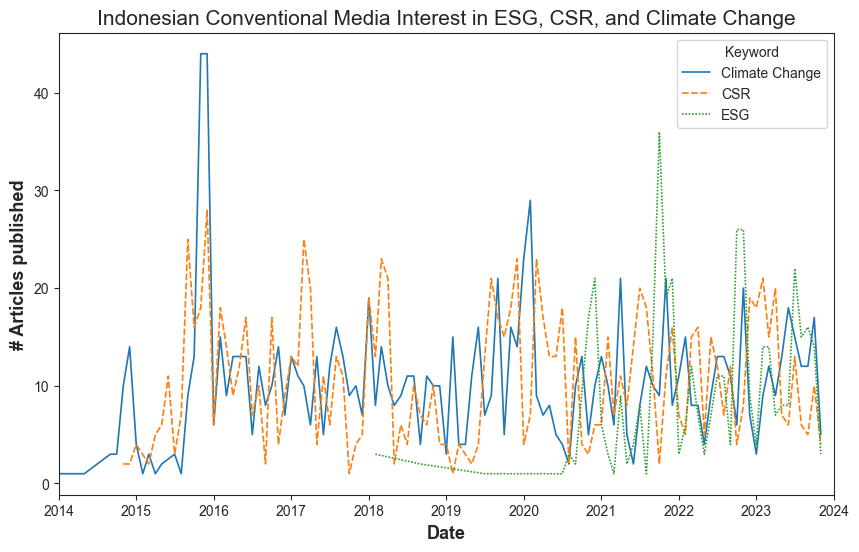

In [9]:
#INTERACTIONS AND ARTICLES PUBLISHED PER MONTH FOR THESE KEYWORDS: CSR, CLIMATE CHANGE, ESG, GLOBAL WARMING, GREENHOUSE GAS, NDC, POLLUTION, SDG

#Import data
mon_2014 = pd.read_excel("Data/Newswhip/Sustainability/2014.xlsx",header=0)
mon_2015 = pd.read_excel("Data/Newswhip/Sustainability/2015.xlsx",header=0)
mon_2016 = pd.read_excel("Data/Newswhip/Sustainability/2016.xlsx",header=0)
mon_2017 = pd.read_excel("Data/Newswhip/Sustainability/2017.xlsx",header=0)
mon_2018 = pd.read_excel("Data/Newswhip/Sustainability/2018.xlsx",header=0)
mon_2019 = pd.read_excel("Data/Newswhip/Sustainability/2019.xlsx",header=0)
mon_2020 = pd.read_excel("Data/Newswhip/Sustainability/2020.xlsx",header=0)
mon_2021 = pd.read_excel("Data/Newswhip/Sustainability/2021.xlsx",header=0)
mon_2022 = pd.read_excel("Data/Newswhip/Sustainability/2022.xlsx",header=0)
mon_2023 = pd.read_excel("Data/Newswhip/Sustainability/2023.xlsx",header=0)

#Concatenates wrangled data
mon_kw = pd.concat([wrangle(mon_2014),wrangle(mon_2015),wrangle(mon_2016),wrangle(mon_2017),wrangle(mon_2018),wrangle(mon_2019),wrangle(mon_2020),wrangle(mon_2021),\
                    wrangle(mon_2022),wrangle(mon_2023)],axis=0,ignore_index=True)

#Runs the categorize function on the keyword column and appends a new column containing the category
mon_kw['Keyword Category'] = mon_kw['Keyword'].apply(kw_categorize)

#Reorder columns
mon_kw = mon_kw.reindex(columns=['Date','Keyword','Keyword Category','Title','Website','Interactions'])


#LINEGRAPH - ARTICLES VS INTERACTIONS FOR ALL KEYWORDS
#Group by date, count number of keyword articles, sums interactions then resets index
forviz = mon_kw[['Date','Keyword','Interactions']].groupby(['Date']).agg({'Keyword':'count','Interactions':'sum'}).rename(columns={'Keyword':'Articles'})
forviz.reset_index(inplace=True)

#Plot dual y axis graph with number of articles on the left y axis and interactions on the right y axis
articles_vs_interactions = dual_lines(forviz,'ticks','Date','Articles','#11898E','Interactions','orange','Sustainable Keywords - Articles vs Interactions')
plt.close()

#LINEGRAPH - NUMBER OF ARTICLES SPLIT BY KEYWORD
#Group by date and keyword category, counts each, renames the column then resets index
#Also sets the date column to datetime for evenly spaced ticks
keywordz = mon_kw[['Date','Keyword Category','Title']].groupby(['Date','Keyword Category']).count().rename(columns={'Title':'Articles'})
keywordz.reset_index(inplace=True)
keywordz['Date'] = pd.to_datetime(keywordz['Date'],yearfirst=True)

#Sets figure size and style
plt.figure(figsize=(10,6))
sns.set_style('ticks')

#Plots linegraph with date on the x-axis, articles on the y-axis, keyword categories distinguished by color, and sets the x ticks to be evenly spaced across all months
ax = sns.lineplot(data=keywordz,x='Date',y='Articles',hue='Keyword Category',style='Keyword Category',linewidth=1.2)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xlim(pd.to_datetime('2014-01',yearfirst=True),pd.to_datetime('2024-01',yearfirst=True))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#Sets axes labels and title
plt.legend(title='Keyword')
plt.xlabel('Date',fontweight='bold',fontsize=13)
plt.ylabel('# Articles published',fontweight='bold',fontsize=13)
plt.title('Indonesian Conventional Media Interest in ESG, CSR, and Climate Change',fontweight='normal',fontsize=15)
plt.show()

In [4]:
#REVENUE PER SHARE VS TOTAL ESG SCORE FROM YAHOO FINANCE FOR TOP 50 INDONESIAN FIRMS

#Imports tickers of top 50 largest companies in Indonesia by market cap into a dataframe. 
#Data is taken from the Indonesian stock exchange and '.JK' is appended to each name as this is the format found on Yahoo Finance
df1 = pd.DataFrame({'Tickers':[x+'.JK' for x in\
                    list(pd.read_excel("Data/Indo_50_Biggest_Companies.xlsx",sheet_name="50 Biggest Market Capitalizatio",header=3,nrows=51,usecols=[2])['Code'])[1:]]})

#Returns a tuple of called data for each ticker in df1. Uses multi-threading with 10 simultaneous workers to speed up query
with ThreadPoolExecutor(max_workers=10) as executor:
   results = executor.map(fetch_data_for_ticker,df1['Tickers'])

#Unpacks the tuples into 4 distinct variables and assigns these to the relevant columns in df1
for result in results:
    ticker, current_price, revenue_per_share, total_esg = result
    df1.loc[df1['Tickers'] == ticker,'Current Share Price'] = current_price
    df1.loc[df1['Tickers'] == ticker,'Revenue per Share'] = revenue_per_share
    df1.loc[df1['Tickers'] == ticker,'Total ESG Rating'] = total_esg

In [5]:
#BCA
#Calls revenue pdf extracter function for BCA data, filters all outliers using 1.5 * IQR, and sorts chronologically
BCA = revenue('BCA',revenuepage=2)
BCA = BCA.loc[BCA['Monthly Interest'] <= (BCA['Monthly Interest'].quantile(0.75) + 1.5*(BCA['Monthly Interest'].quantile(0.75) - BCA['Monthly Interest'].quantile(0.25)))].sort_values(by='Date',axis=0,ascending=True,ignore_index=True)

#Fills each year's customer count on December every year, pulling numbers manually from BCA's yearly reports
BCA['Customers'] = 0
BCA.loc[len(BCA)] = ['2022-12',0,27900000]
BCA.loc[len(BCA)] = ['2021-12',0,22800000]
BCA.loc[len(BCA)] = ['2020-12',5372763,19471200]
BCA.loc[BCA['Date'] == '2019-12','Customers'] = 17017829
BCA.loc[BCA['Date'] == '2018-12','Customers'] = 14601297
BCA.sort_values(by='Date',axis=0,ascending=True,ignore_index=True,inplace=True)

#Adds empty date columns for all missing dates between 2018 to 2023
for year in ['2018','2019','2020','2021','2022','2023']:

    #Returns all the months present for each respective year
    all_dates = [int(x[5:7]) for x in BCA.loc[BCA['Date'].str.contains(year),'Date'].tolist()]

    #Loops through months 1 (January) through 12 (December) and saves the months not present in all_dates
    missing_dates = [str(x) for x in list(range(1,13,1)) if x not in all_dates]

    #Converts to leading zero month format
    missing_dates = ['0'+x if len(x) == 1 else x for x in missing_dates]

    #Appends the missing months at the bottom of the BCA dataframe with no monthly interest or customer count
    for date in missing_dates:
        BCA.loc[len(BCA)] = [year + '-' + date,0,0]
        
#Sort chronologically
BCA.sort_values(by='Date',axis=0,ascending=True,ignore_index=True,inplace=True)

#Replaces 0 interest values with None to be able to use interpolate (formula for creating missing entries based on the surrounding data)
BCA['Monthly Interest'].replace(0,np.nan,inplace=True)
BCA['Monthly Interest'].interpolate(inplace=True)
BCA['Monthly Interest'] = BCA['Monthly Interest'].astype('int')

#Unifies all months in each year with the customer base value
for year in ['2018','2019','2020','2021','2022','2023']:
    BCA.loc[BCA['Date'].str.contains(year),'Customers'] = BCA.loc[BCA['Date'].str.contains(year),'Customers'].sum()

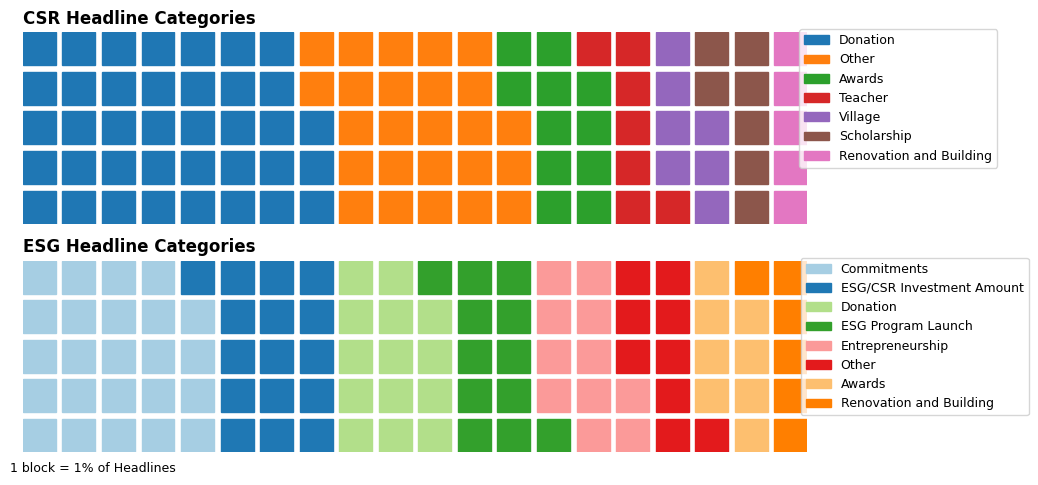

,Date,Keyword,Title,Website,Interactions,ESG Category


In [5]:
#ESG AND CSR ARTICLE SPLIT

#Loops through all the CSR files and creates one master dataframe
comp_csr = pd.DataFrame()
for file in os.listdir('Data/Newswhip/Company_and_ESG/CSR'):
    csv = pd.read_csv(os.path.join('Data/Newswhip/Company_and_ESG/CSR',file))
    comp_csr = pd.concat([comp_csr,wrangle(csv)],axis=0,ignore_index=True)

#Loops through all the ESG files and creates one master dataframe
comp_esg = pd.DataFrame()
for file in os.listdir('Data/Newswhip/Company_and_ESG/ESG'):
    csv = pd.read_csv(os.path.join('Data/Newswhip/Company_and_ESG/ESG',file))
    comp_esg = pd.concat([comp_esg,wrangle(csv)],axis=0,ignore_index=True)

#Categorise the headlines 
comp_csr['CSR Category'] = comp_csr['Title'].apply(esg_categorize)
comp_esg['ESG Category'] = comp_esg['Title'].apply(esg_categorize)

#Prepares data for waffle chart
csr_categories = pd.DataFrame(comp_csr.loc[~comp_csr['CSR Category'].isnull(),'CSR Category'].value_counts(normalize=True,sort=True)).reset_index().rename(columns={'count':'Count'})
others = csr_categories.loc[csr_categories['proportion'] < 0.05,'CSR Category'].tolist()
comp_csr.loc[comp_csr['CSR Category'].isin(others),'CSR Category'] = 'Other'
csr_categories = pd.DataFrame(comp_csr.loc[~comp_csr['CSR Category'].isnull(),'CSR Category'].value_counts(sort=True)).reset_index().rename(columns={'count':'Count'})

#Prepares data for waffle chart
esg_categories = pd.DataFrame(comp_esg.loc[~comp_esg['ESG Category'].isnull(),'ESG Category'].value_counts(normalize=True,sort=True)).reset_index().rename(columns={'count':'Count'})
otherss = esg_categories.loc[esg_categories['proportion'] < 0.05,'ESG Category'].tolist()
comp_esg.loc[comp_esg['ESG Category'].isin(otherss),'ESG Category'] = 'Other'
esg_categories = pd.DataFrame(comp_esg.loc[~comp_esg['ESG Category'].isnull(),'ESG Category'].value_counts(sort=True)).reset_index().rename(columns={'count':'Count'})

#Plots waffle chart
fig = plt.figure(FigureClass=Waffle,plots={\
            211:{'values':csr_categories['Count'],'labels':csr_categories['CSR Category'].tolist(),'cmap_name':'tab10','legend':{'loc':'upper right','alignment':'left','bbox_to_anchor':(1.25,1.05),'fontsize':9},'title':{'label':'CSR Headline Categories','loc':'left','fontweight':'demibold'}},\
            212:{'values':esg_categories['Count'],'labels':esg_categories['ESG Category'].tolist(),'cmap_name':'Paired','legend':{'loc':'upper right','alignment':'left','bbox_to_anchor':(1.29,1.05),'fontsize':9},'title':{'label':'ESG Headline Categories','loc':'left','fontweight':'demibold'}}},\
            rows=5,columns=20,figsize=(10,5))
fig.supxlabel('1 block = 1% of Headlines',fontsize=9,x='0.085',y='0.04')
plt.show()